In [2]:
# Permet de tout executer au lancement du notebook + conserver le notebook actif pendant 2h
from IPython.display import Javascript
from masquer import *
Javascript("""
function repeter(){
IPython.notebook.kernel.execute("a=1");
}
// execute a = 1 en python toutes les 8 minutes pendant 2h
let timerId = setInterval(() => repeter(), 4800);
setTimeout(() => { clearInterval(timerId); alert('fin de cession'); }, 7200000);

// Supprimer la taille limite pour la sortie d'une cellule
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};
IPython.notebook.kernel.execute("url = '" + window.location + "'");

// Exécuter toutes les cellule du notebook
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            
                
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
                Jupyter.actions.call('jupyter-notebook:hide-header')

        }
    );""")

<IPython.core.display.Javascript object>

# <span style="color:red;"><center> TD - Algorithme k-NN</span>

Dans ce TD, nous allons utilser l'algorithme k-NN, d'abord pour classer des fleurs (des iris) puis pour reconnaître des chiffres écrits à la main. Ces 2 exemples sont deux grands classiques dans le domaine du machine learning.

## 1. Classer des fleurs

### 1.1 Introduction

En 1936, Edgar Anderson a collecté des données sur 3 espèces d'iris :
- **iris setosa**
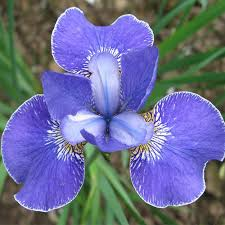



- **iris versicolor**
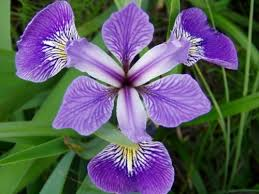

- **iris virginica**
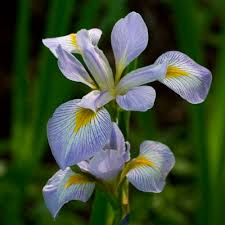


Pour chaque iris étudié, Anderson a mesuré (en cm) :
- la largeur des sépales
- la longueur des sépales
- la largeur des pétales
- la longueur des pétales

Par souci de simplification, nous nous intéresserons uniquement à la largeur et à la longueur des pétales.

Pour chaque iris mesuré, Anderson a aussi noté l'espèce ("iris setosa", "iris versicolor" ou "iris virginica")

Vous trouverez 150 de ces mesures dan le fichier ``Files/iris.csv``.

En résumé, vous trouverez dans ce fichier :

- la longueur des pétales
- la largeur des pétales
- l'espèce de l'iris (au lieu d'utiliser les noms des espèces, on utilisera des chiffres : 0 pour "iris setosa", 1 pour "iris versicolor" et 2 pour "iris virginica")

|petal_length|petal_width|species|
|:-:|:-:|:-:|
|1.4|0.2|0|
|1.4|0.2|0|
|1.3|0.2|0|
|1.5|0.2|0|
|1.4|0.2|0|
|1.7|0.4|0|

Vous devez savoir que ce jeu de données a, aujourd'hui, un intérêt purement pédagogique. En effet, il est exclusivement utilisé par des personnes désirant s'initier aux algorithmes de machine learning.


### 1.2 Représentation des données

Afin de visualiser les données du fichier `iris.csv`, traçons un graphique de la largeur des pétales en fonction de leur longueur, en utilisant des couleurs différentes selon l'espèce d'iris.


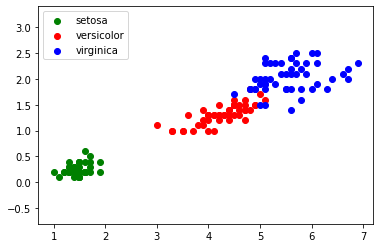

In [3]:
import pandas #pour ouvrir le fichier csv
import matplotlib.pyplot as plt #pour tracer le graphique
iris=pandas.read_csv("Files/iris.csv") #on ouvre le fichier
x=iris.loc[:,"petal_length"] #x = longueur
y=iris.loc[:,"petal_width"] #y=largeur
N=len(x) # N est le nombre de données dans le jeu de départ
lab=iris.loc[:,"species"]#lab=espèce
plt.axis('equal') #repère orthonormé
# définition des points pour chaque espèce
plt.scatter(x[lab == 0], y[lab == 0], color='g', label='setosa')
plt.scatter(x[lab == 1], y[lab == 1], color='r', label='versicolor')
plt.scatter(x[lab == 2], y[lab == 2], color='b', label='virginica')
plt.legend() #ajout de la légende
plt.show() #traçage du graphique

**Q1. Que remarque-t-on sur le graphique ci-dessus qui permet d'être confiant quant à l'efficacité de l'algorithme k-NN pour classer ces iris ?** 

**Réponse 1 :**

Répondre ici ...

Imaginons que vous trouviez une iris d'espèce inconnnue. Vous mesurez ses pétales et vous trouvez qu'ils font 0,5 cm de large et 2 cm de long.

**Q2. Ajouter cet iris en noir (color='k') et avec le label "inconnue" sur le graphique précédent.** 

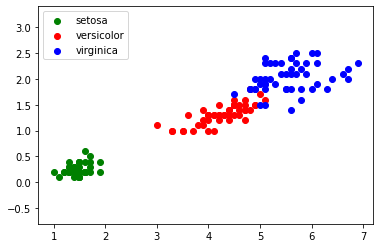

In [4]:
# Question 2
# ajouter ici le point sur le graphique pour l'iris inconnue

plt.axis('equal') #repère orthonormé
# définition des points pour chaque espèce
plt.scatter(x[lab == 0], y[lab == 0], color='g', label='setosa')
plt.scatter(x[lab == 1], y[lab == 1], color='r', label='versicolor')
plt.scatter(x[lab == 2], y[lab == 2], color='b', label='virginica')
plt.legend() #ajout de la légende
plt.show() #traçage du graphique

**Q3. D'après vous quelle est l'espèce de cet iris inconnue ? Justifier.** 

**Réponse Q3 :**

Répondre ici ...

En fait, vous avez naturellement utilisé un algorithme de plus proches voisins pour répondre à la question précédente car dans ce cas la réponse était évidente.

Supposons à présent que vous trouviez une iris dont la largeur de pétale est de 0,75 cm et la longueur de pétale est 2,5 cm.

**Q4. Toujours sur le même graphique, remplacez l'iris inconnue précédente par celle-ci.** 

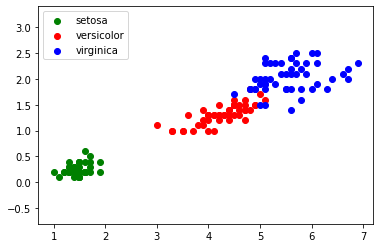

In [5]:
# Question 4
# ajouter ici le point sur le graphique pour l'iris inconnue

plt.axis('equal') #repère orthonormé
# définition des points pour chaque espèce
plt.scatter(x[lab == 0], y[lab == 0], color='g', label='setosa')
plt.scatter(x[lab == 1], y[lab == 1], color='r', label='versicolor')
plt.scatter(x[lab == 2], y[lab == 2], color='b', label='virginica')
plt.legend() #ajout de la légende
plt.show() #traçage du graphique

Cette fois son identification est nettement moins évidente. Voyons quels sont ses 3 plus proches voisins :
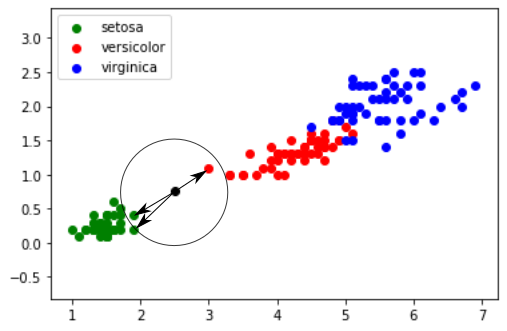

Parmi ses 3 plus proches voisins, l'espèce setosa est majoritaire, on peut donc raisonnablement la classer dans la même espèce.

### 1.3 Recherche des plus proches voisins

On veut à présent confirmer le résultat graphique précédent en effectuant une recherche réelle des plus proches voisins parmi les données.

Pour cela, il nous faut tout d'abord définir une fonction `distance(pt1,pt2)` qui prend en argument 2 tuples (de dimension quelconque) et renvoie leur distance euclidienne. On rappelle qu'à 2 dimensions, la distance euclidienne entre $P_1=(x_1,y_1)$ et $P_2=(x_2,y_2)$ est définie par $d=\sqrt{(x_2-x_1)^2+(y_2-y_1)^2}$.

**Q5. Ecrire la fonction `distance(pt1,pt2)`.** 

In [6]:
# Question 5
from math import sqrt
def distance(pt1,pt2):
    """Calcul de la distance euclidienne"""
    ...  # à compléter ...

**Vérifier que les tests ci-dessous donnent bien 0.0, 1.0, $\sqrt{2}$ et $\sqrt{5}$.**

In [7]:
print(distance ((1,1),(1,1)))
print(distance ((1,1),(1,2)))
print(distance ((1,1),(2,2)))
print(distance ((1,1),(2,3)))

None
None
None


**Q6. Construire la liste des distances `dist_list` qui contient la distance entre l'iris inconnue et toutes les iris déjà connues puis afficher ses 10 premières valeurs.** 

In [8]:
# Question 6
dist_list=[]
iris_inconnue=(2.5, 0.75)
... # à compléter

Ellipsis

**Q7. Construire la liste `voisins` qui contient les tuples `(distance, indice)` regroupant pour chaque iris connue, sa distance par rapport à l'iris inconnue et son indice dans le jeu de données; puis afficher ses 10 premières valeurs.** 

In [9]:
# Question 7
voisins=[]
... # à compléter

Ellipsis

**Q8. A l'aide de la fonction sorted, trier la liste `voisins` et vérifier que le tri s'est bien fait par rapport à la distance en affichant ses 10 premières valeurs.** 

In [10]:
# Question 8
... # à compléter

**Q9. Afficher l'indice et l'espèce des 3 plus proches voisins de l'iris inconnue. On rappelle que l'espèce de chaque iris est contenue dans la liste `lab`.** 

In [11]:
# Question 9
... # à compléter

**Résultat**

La plus proche est l'iris d'indice 98 et est de type 1, c'est-à-dire *versicolor*. Les deux suivantes sont les iris d'indice 44 et 24 et sont de type 0, soit *setosa*. Ce qui correspond bien au résultat graphique trouvé précédemment et confirme que l'iris inconnue serait plutôt de type *setosa*.

**Q10. Vérifier que si on considère à présent les 5 plus proches voisins, le résultat est différent.** 

In [12]:
# Question 10
... # à compléter

## 2. Reconnaître des chiffres

Nous allons maintenant utiliser l'algorithme k-NN dans un cas nettement plus complexe où il s'agit de reconnaître des chiffres écrits à la main.

### 2.1 Le jeu de données

Nous allons utiliser un jeu de donnée (*dataset*) très célèbre, appelé **MNIST**. Il est constitué d'un ensemble de 70000 images 28x28 pixels en niveaux de gris et des étiquettes correspondantes (chiffre entre 0 et 9).

L'objectif de ce jeu de données était de permettre à un ordinateur d'apprendre à reconnaître des nombres manuscrits automatiquement (pour lire des chèques par exemple). Ce dataset utilise des données réelles qui ont déjà été pré-traitées pour être plus facilement utilisables par un algorithme.

Voici un aperçu des images qu'il contient :
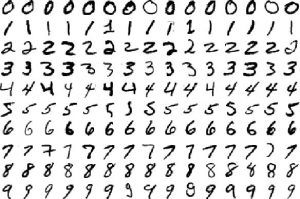


### 2.2 Charger les données

En fait, les 70 000 images du jeu d'origine sont trop lourdes pour être chargées et traitées dans le cadre de ce notebook Jupyter. Nous allons donc travailler sur un extrait de seulement 10 000 images.

Le fichier `Files/t10k-images.idx3-ubyte` contient les images et le fichier `Files/t10k-labels.idx1-ubyte` contient les étiquettes correspondantes.

Pour charger ces données en mémoire, on utilise la méthode `loadlocal_mnist` de la bibliothèque `mlxtend.data` qui est faite pour cela.

In [13]:
from mlxtend.data import loadlocal_mnist
x, y = loadlocal_mnist(images_path='Files/t10k-images.idx3-ubyte',labels_path='Files/t10k-labels.idx1-ubyte')
# x est une liste qui contient les images sous forme de listes contenant les valeurs de chaque pixel en niveaux de gris
# y est la liste des étiquettes
print(x[0]) # affichage de la première image
print(y[0]) # affichage de la première étiquette

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 222 254 254 254
 254 241 198 198 198 198 198 198 198 198 170  52   

**Q11. Afficher la première image sous la forme d'un tableau de 28 lignes et de 28 colonnes.**

On utilisera :
- `print("{:^3d}".format(n), end=' ')` qui permet d'afficher un entier n de façon centrée sur 3 caractères.
- `print("\n")` qui permet d'aller à la ligne (sans rien afficher)
- deux boucles for imbriquées

In [14]:
# Question 11
... # à compléter

Vous devriez reconnaître sans peine le chiffre 7 dans le tableau ci-dessus.

### 2.2 Training et testing set

Habituellement en *machine learning*, on sépare le jeu de données initial en *training set* (jeu d'entrainement) qu'on utilise pour la phase d'apprentissage et *testing set* (jeu de test) qu'on utilise pour vérifier si l'algorithme fonctionne. Le code ci-dessous permet d'utiliser une répartition classique de 80/20.

La méthode `train_test_split` est issue de la bibliothèque Sickit-Learn qui est très utilisée pour le *machine learning* en Python. Elle permet de partager très facilement notre jeu de données.

In [15]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y, train_size=0.8)
# xtrain et ytrain contiennent les 8000 images et étiquettes d'entrainement
# xtest et ytest contiennent les 2000 images et étiquettes de test

### 2.3 Phase d'entrainement

Dans le cas particulier de l'algorithme k-NN, la phase d'entrainement n'en est pas vraiment une car l'algorithme n'optimise aucun paramètre. Il se contente en fait de mémoriser le *training set* afin de pouvoir l'utiliser ensuite par comparaison.

Afin de rendre son utilisation plus rapide par la suite, nous allons commencer par créer un objet de type "classifieur" dans lequel nous allons charger notre jeu d'entrainement.

In [16]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=3) # création d'un 3-NN classifieur
knn.fit(xtrain, ytrain) #chargement des données d'entrainement dans le classifieur

KNeighborsClassifier(n_neighbors=3)

### 2.3 Phase de test

C'est maintenant que cela devient intéressant. Grâce à notre classifieur, nous pouvons calculer facilement le pourcentage d'érreur (ou de réussite) de notre algorithme k-NN pour k = 3.

Le code ci-dessous vérifie si notre algorithme reconnait correctement ou pas les 2000 image de notre jeu de test et affiche le pourcentage d'erreur obtenu.

Pour calculer la distance entre 2 images, on utilise la distance euclidienne vu précédemment en considérant chaque image comme un point dans un espace à $28 \times 28 = 784$ dimensions.

**ATTENTION :** Cela peut prendre un peu de temps, soyez patient.

In [17]:
# Calcul du pourcentage d'erreur
error =(1 - knn.score(xtest, ytest))*100 # knn.score est entre 0 et 1 et donne le taux de réussite
print('Erreur: {:.2f} %'.format(error)) # affichage du pourcentage d'erreur avec 2 chiffres après la virgule

Erreur: 5.15 %


L'algorithme se trompe donc dans environ 5% des cas mais "lit" correctement le chiffre dans près de 95% des cas, ce qui est quand même très satisfaisant vu la simplicité de l'algorithme et la faible taille du jeu de données utilisé.

Pour information, le record est de 0,18% sur le dataset NMIST. Il est détenu par un algorithme basé sur l'utilisation de 3 réseaux de neurones simultanément, développé à l'Université de Virginie.

### 2.4 Choix de la valeur de k

Pour terminer, on essayer de trouver la valeur de k la plus adaptée dans ce cas précis. Pour cela, il suffit de tester l'algorithme avec différentes valeurs de k (par exemple de k = 2 à k = 14) et de choisir celui qui donne le plus petit pourcentage d'erreur.

C'est ce que fait le code ci-dessous, en traçant ensuite le graphe du pourcentage d'erreurs en fonction de la valeur de k.

**ATTENTION :** Cela prend encore plus de temps, soyez encore plus patient.

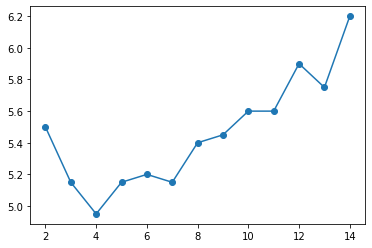

In [18]:
errors = [] # liste des pourcentage d'erreurs
for k in range(2,15): # on fait varier k de 2 à 14
    knn = neighbors.KNeighborsClassifier(k) # pour chaque valeur de k, on crée un classifieur
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest))) # et on calcule le pourcentage d'erreurs
plt.plot(range(2,15), errors, 'o-') # définition du graphique
plt.show() # affichage du graphique

**Q12. D'après ce graphique, quelle est la meilleure valeur à choisir pour k ? Compléter le code ci-dessous avec cette valeur.**


In [19]:
# Question 12
knn = neighbors.KNeighborsClassifier(k) # on crée un classifieur avec la meilleure valeur de k
knn.fit(xtrain, ytrain) #chargement des données d'entrainement dans le classifieur

KNeighborsClassifier(n_neighbors=14)

### 2.5 Visualisation des résultats

Il peut être intéressant de comparer quelques images avec leurs étiquettes telles qu'elles ont été déterminée par l'algorithme.

Le code ci-dessous crée la liste `predicted` des valeurs prédites pour le jeu de test et la liste `images` des images de test sous la forme de tableaux pour pouvoir être affichées plus facilement.

In [20]:
import numpy as np

# On récupère les prédictions sur les données test
predicted = knn.predict(xtest)
# On redimensionne les données sous forme de tableau de 28 par 28
images = xtest.reshape((-1, 28, 28))

Le code ci-dessous sélectionne 12 données au hasard dans le jeu de test et affiche les images et les prédictions correspondantes.

2 9 9 3 2 3 6 3 2 9 9 2 

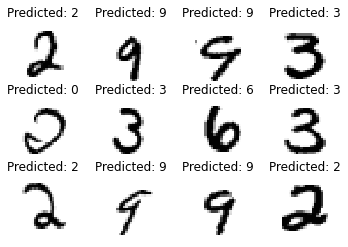

In [21]:
# On tire au hasars le numéro de 12 images dans le jeu de test
select=np.random.randint(0,len(xtest),12)
# On affiche les images avec la prédiction associée
i=0
for indice in select: # on ajoute les 12 images une par une
    i+=1
    plt.subplot(3,4,i) # graphe numéro i sur une grille de 4 par 3
    plt.axis('off')
    plt.imshow(images[indice],cmap=plt.cm.gray_r,interpolation="nearest") # affichage de l'image
    plt.title('Predicted: {}'.format(predicted[indice]) ) # affichage de l'étiquette prédite
    print(ytest[indice], end=" ") # affichage des étiquettes attendues, pour vérification

plt.show()


**Remarque :** Dans les images affichées ci-dessus, certaines prédictions peuvent être fausses. Si ce n'est pas le cas, exécuter à nouveau la cellule pour le vérifier.

**Q13. Compléter le code ci-dessous pour que la liste `faux` contienne les indices des images du jeu de test pour lesquelles la prédiction est fausse.**

On rappelle que les étiquette prédites sont dans la listes `predicted` alors que celles attendues sont dans la liste `ytest`.


In [23]:
# Question 13
faux=[]
... # à compléter
        
# on affiche les images et les prédictions (erronées) associées à ces images
i=0
for indice in faux[0:12]: # on ajoute les 12 pemières images une par une
    i+=1
    plt.subplot(3,4,i) # graphe numéro i sur une grille de 4 par 3
    plt.axis('off')
    plt.imshow(images[indice],cmap=plt.cm.gray_r,interpolation="nearest") # affichage de l'image
    plt.title('Predicted: {}'.format(predicted[indice]) ) # affichage de l'étiquette prédite
    print(ytest[indice], end=" ") # affichage des étiquettes attendues, pour vérification

plt.show()